### BrainBERT for The TUH Abnormal EEG Corpus (TUAB) dataset
#### In this notebook, the full pipeline is: load data → select EEG channel → extract fixed-length segments → preprocessing (resample + STFT) → load pretrained BrainBERT → extract embeddings → visualize representations
##### BrainBERT on TUAB dataset: 
1. Load raw EEG recordings from the TUH Abnormal EEG Corpus (TUAB), select a single EEG channel as input, since the pretrained BrainBERT model is designed for single-channel spectral representations.
2. Extract a fixed-length 10-second EEG segment from each recording for demo.

In [1]:
import os, sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import mne
from scipy import signal

In [2]:
cwd = Path.cwd()
root = cwd.parent.parent

brainbert_root = root / "BrainBERT"
if str(brainbert_root) not in sys.path:
    sys.path.insert(0, str(brainbert_root))
import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = root / "pretrained_weights" / "stft_large_pretrained.pth"
print("CKPT:", ckpt_path)

edf_path = root / "data" / "tuh_eeg" / "v3.0.1" / "edf" / "train" / "abnormal" / "01_tcp_ar" / "aaaaadsy_s004_t004.edf"
print("EDF:", edf_path)

raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
raw.pick_types(eeg=True, eog=False, ecg=False, emg=False, stim=False, misc=False)

print("Channels:", raw.ch_names[:10], " ... total:", len(raw.ch_names))
print("SFreq:", raw.info["sfreq"], "Hz")
print("Duration:", raw.n_times / raw.info["sfreq"], "sec")


CKPT: f:\TUD\Phd_application\Oulu\Code\pretrained_weights\stft_large_pretrained.pth
EDF: f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\abnormal\01_tcp_ar\aaaaadsy_s004_t004.edf
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channels: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF']  ... total: 33
SFreq: 256.0 Hz
Duration: 1344.0 sec


In [3]:
def resample_to_length(wav_1d, target_len=2048):
    wav_1d = wav_1d.astype(np.float32)
    if len(wav_1d) == target_len:
        return wav_1d
    return signal.resample(wav_1d, target_len).astype(np.float32)

def safe_zscore(x, axis=-1, eps=1e-6):
    mean = np.mean(x, axis=axis, keepdims=True)
    std  = np.std(x, axis=axis, keepdims=True)
    std = np.where(std < eps, 1.0, std)
    return (x - mean) / std

def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5

    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = safe_zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip] + 1e-8)
        t = t[clip:-clip]

    Zxx = np.nan_to_num(Zxx, nan=0.0, posinf=0.0, neginf=0.0)
    return f, t, Zxx

In [ ]:
def get_one_channel_segment(raw, ch_idx=0, start_sec=0.0, dur_sec=10.0):
    sfreq = raw.info["sfreq"]
    start_samp = int(start_sec * sfreq)
    n_samp = int(dur_sec * sfreq)
    stop_samp = min(start_samp + n_samp, raw.n_times)

    x = raw.get_data(picks=[ch_idx], start=start_samp, stop=stop_samp)[0]
    x = x.astype(np.float32) * 1e6
    return x, sfreq


def plot_stft_from_1d(wav_1d, title="STFT (BrainBERT style)"):
    wav = resample_to_length(wav_1d, target_len=2048)
    nperseg = 400
    noverlap = 350
    hop = nperseg - noverlap

    f, t, linear = get_stft(
        wav, 2048,
        clip_fs=40,
        nperseg=nperseg,
        noverlap=noverlap,
        normalizing="zscore",
        return_onesided=True
    )

    x_samples = np.arange(linear.shape[1]) * hop
    plt.figure(figsize=(15, 3))
    f = f.copy()
    f[-1] = 200
    g = plt.pcolormesh(x_samples, f, linear, shading="gouraud", vmin=-3, vmax=5)
    cbar = plt.colorbar(g)
    cbar.ax.set_ylabel("Power (Arbitrary units)")
    plt.xlabel("Sample index")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [5]:
def build_model(ckpt_path, device):
    init_state = torch.load(ckpt_path, map_location="cpu")
    model_cfg = init_state["model_cfg"]
    model = models.build_model(model_cfg)
    model.load_weights(init_state["model"])
    model.to(device)
    model.eval()
    return model

@torch.no_grad()
def brainbert_out_one_channel(model, wav_1d, device, target_len=2048):
    wav = resample_to_length(wav_1d, target_len=target_len)

    _, _, linear = get_stft(
        wav, 2048,
        clip_fs=40,
        nperseg=400,
        noverlap=350,
        normalizing="zscore",
        return_onesided=True
    )

    inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to(device)  # (1, ts, 40)
    mask = torch.zeros(inputs.shape[:2], dtype=torch.bool, device=device)

    out = model.forward(inputs, mask, intermediate_rep=True)  # (1, ts, D)
    return out

def plot_brainbert_official(out, title="BrainBERT Feature Representation"):
    output_features = out.squeeze(0).cpu().numpy()  # (ts, D)
    plt.figure(figsize=(10, 6))
    plt.imshow(output_features.T, aspect="auto", cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Activation")
    plt.xlabel("Time Steps (STFT frames)")
    plt.ylabel("Feature Dimension")
    plt.title(title)
    plt.tight_layout()
    plt.show()


d:\Anaconda3\envs\brainbert\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


BrainBERT model loaded.
Segment shape: (2560,) orig sfreq: 256.0


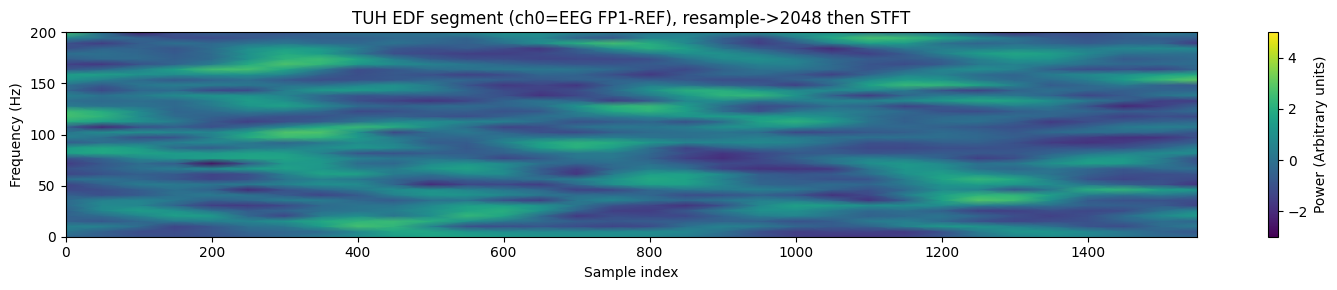

d:\Anaconda3\envs\brainbert\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


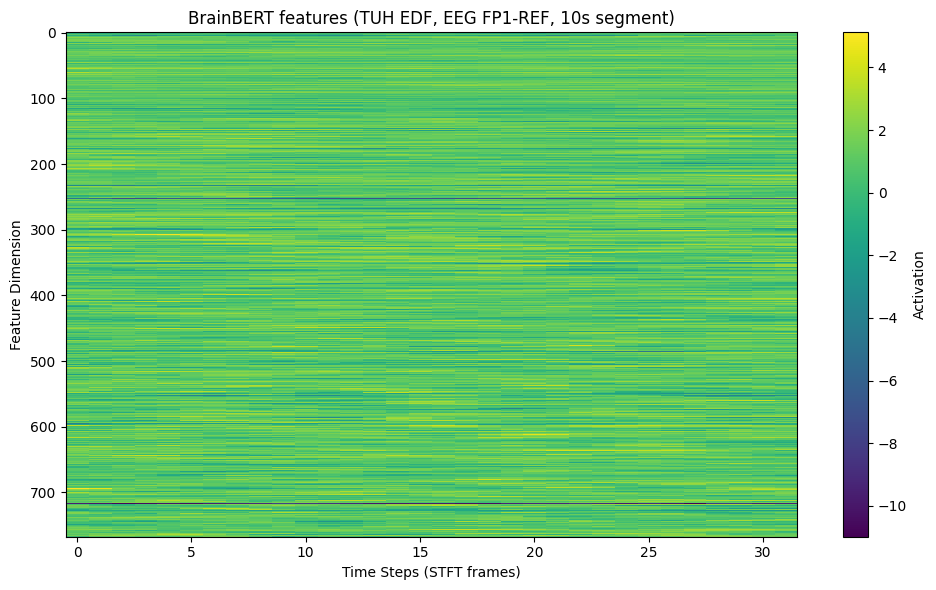

In [6]:
model = build_model(ckpt_path, device)
print("BrainBERT model loaded.")

x_seg, sfreq = get_one_channel_segment(raw, ch_idx=0, start_sec=0.0, dur_sec=10.0)
print("Segment shape:", x_seg.shape, "orig sfreq:", sfreq)

plot_stft_from_1d(x_seg, title=f"TUH EDF segment (ch0={raw.ch_names[0]}), resample->2048 then STFT")

out = brainbert_out_one_channel(model, x_seg, device, target_len=2048)
plot_brainbert_official(out, title=f"BrainBERT features (TUH EDF, {raw.ch_names[0]}, 10s segment)")